In [100]:
import pyspark
import warnings
warnings.filterwarnings("ignore")
import os 
dir_path = os.path.dirname(os.path.realpath('__file__'))
data_path=dir_path+"/bank/bank.csv"

sc = spark.sparkContext

# Load csv file 

In [148]:
df = sc.textFile(data_path)
header = df.first()
df =df.filter(lambda line: line != header)
df_var = df.map(lambda k: k.split(";"))
colname=header.split(";")
colname = [w.replace('"', '') for w in colname]
print colname
df=df_var.toDF(colname)
df.take(2)

[u'age', u'job', u'marital', u'education', u'default', u'balance', u'housing', u'loan', u'contact', u'day', u'month', u'duration', u'campaign', u'pdays', u'previous', u'poutcome', u'y']


[Row(age=u'30', job=u'"unemployed"', marital=u'"married"', education=u'"primary"', default=u'"no"', balance=u'1787', housing=u'"no"', loan=u'"no"', contact=u'"cellular"', day=u'19', month=u'"oct"', duration=u'79', campaign=u'1', pdays=u'-1', previous=u'0', poutcome=u'"unknown"', y=u'"no"'),
 Row(age=u'33', job=u'"services"', marital=u'"married"', education=u'"secondary"', default=u'"no"', balance=u'4789', housing=u'"yes"', loan=u'"yes"', contact=u'"cellular"', day=u'11', month=u'"may"', duration=u'220', campaign=u'1', pdays=u'339', previous=u'4', poutcome=u'"failure"', y=u'"no"')]

# Handle missing data. 
There is no missing data. 

In [101]:
from pyspark.sql.functions import col,sum
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()


+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|  0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+



# Feature transformation
All of the feature are string. First we need to convert some of them back to interger. 

In [149]:
from pyspark.sql.types import IntegerType

intcol=['age','balance','day','duration','campaign','pdays','previous']
for col in intcol:
    df = df.withColumn(col, df[col].cast(IntegerType()))

df.printSchema()
 

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



Next we convert catergorical variable to int by using StringIndexer. 


In [150]:
from pyspark.ml.feature import StringIndexer
catacol=['job','marital','education','default','housing','loan','contact','month','poutcome','y']
for col in catacol:
    indexer = StringIndexer(inputCol=col, outputCol=col+'index')
    df = indexer.fit(df).transform(df)
    df=df.drop(col)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- jobindex: double (nullable = true)
 |-- maritalindex: double (nullable = true)
 |-- educationindex: double (nullable = true)
 |-- defaultindex: double (nullable = true)
 |-- housingindex: double (nullable = true)
 |-- loanindex: double (nullable = true)
 |-- contactindex: double (nullable = true)
 |-- monthindex: double (nullable = true)
 |-- poutcomeindex: double (nullable = true)
 |-- yindex: double (nullable = true)



# EDA by pandas
Now we check the y target distribution from the histogram. It indicated the inbalance data. 
We need to use f1 score to evalute the model performance. 

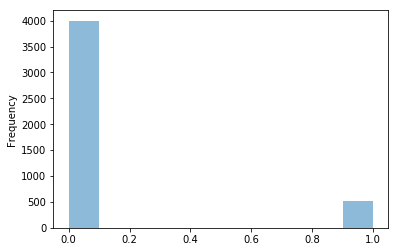

In [104]:
import matplotlib
import matplotlib.pyplot as plt
import pandas
pdf=df.toPandas()
pdf['yindex'].plot.hist(alpha=0.5)

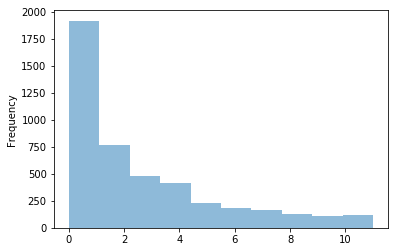

In [96]:
pdf['jobindex'].plot.hist(alpha=0.5)

Check correlation between target

In [151]:
from pyspark.mllib.stat import Statistics
import numpy as np
#corr_mat=Statistics.corr(features, method="pearson")

colname=list(df.columns)
colname.pop()# remove 'yindex'
corr=[]
for col in colname:
    corr.append([col,df.stat.corr(col, "yindex")])
df_corr = sc.parallelize(corr).toDF(['name','corr'])
df_corr=df_corr.sort('corr')
df_corr.show()

+--------------+--------------------+
|          name|                corr|
+--------------+--------------------+
|  contactindex| -0.0822292716433754|
|     loanindex|-0.07051703515462054|
|      campaign|-0.06114743110383...|
|           day|-0.01124420792517261|
|educationindex|0.001209739207648...|
|  defaultindex|0.001302652645621...|
|       balance|0.017905098387636386|
|      jobindex| 0.03514967540430604|
|           age| 0.04509180287499891|
|  maritalindex|0.061242185569287504|
|         pdays| 0.10408681940919907|
|  housingindex| 0.10468340035106322|
|      previous| 0.11671443565541814|
|    monthindex|  0.1890303686445766|
| poutcomeindex| 0.24656553929214323|
|      duration| 0.40111830327523973|
+--------------+--------------------+



# Prepare training data

In [152]:
from pyspark.ml.linalg import DenseVector
input_data=df.rdd.map(lambda x:(x[-1],DenseVector(x[:-2])))
df=spark.createDataFrame(input_data,["label","features"])
df.take(2)

[Row(label=0.0, features=DenseVector([30.0, 1787.0, 19.0, 79.0, 1.0, -1.0, 0.0, 8.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 8.0])),
 Row(label=0.0, features=DenseVector([33.0, 4789.0, 11.0, 220.0, 1.0, 339.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]))]

In [158]:

from pyspark.ml.feature import StandardScaler
sclr=StandardScaler(inputCol='features',outputCol='features_scaled')
scaler=sclr.fit(df)
scaled_df=scaler.transform(df)
scaled_df.take(2)


[Row(label=0.0, features=DenseVector([30.0, 1787.0, 19.0, 79.0, 1.0, -1.0, 0.0, 8.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 8.0]), features_scaled=DenseVector([2.8366, 0.5938, 2.3037, 0.304, 0.3216, -0.01, 0.0, 2.9894, 0.0, 2.3114, 0.0, 2.0174, 0.0, 0.0, 3.226])),
 Row(label=0.0, features=DenseVector([33.0, 4789.0, 11.0, 220.0, 1.0, 339.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]), features_scaled=DenseVector([3.1202, 1.5912, 1.3337, 0.8466, 0.3216, 3.3859, 2.3619, 1.4947, 0.0, 0.0, 0.0, 0.0, 2.7787, 0.0, 0.0]))]

In [174]:
train_df,test_df=df.randomSplit([0.8,0.2],seed=42)
test_df.take(2)

[Row(label=0.0, features=DenseVector([20.0, 291.0, 11.0, 172.0, 5.0, 371.0, 5.0, 10.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0])),
 Row(label=0.0, features=DenseVector([20.0, 1191.0, 12.0, 274.0, 1.0, -1.0, 0.0, 10.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 6.0]))]

In [226]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train_df)

# Compute raw scores on the test set
y_p=lrModel.transform(test_df)
y_pred=y_p.select('prediction').rdd.map(lambda x:x[0])#predicted
y_t=y_p.select('label').rdd.map(lambda x:x[0])#target
predictionAndLabels=y_pred.zip(y_t)
predictionAndLabels.collect()
print 'training done'    

training done


# Model evaluation 

In [230]:

metrics=MulticlassMetrics(predictionAndLabels)
#precision = metrics.precision()
#recall = metrics.recall()
f1Score = metrics.fMeasure()

print('f1score %s'%f1Score)
spark.stop()

f1score 0.90465631929


# Future work 
1. Feature engineering: one to hot code catagorical variable, more EDA.
2. n-way interaction 
3. Try random forest classifier, xgboost and other ensemble model
4. Stacking ensemble. 
5. Learning curve. 
